<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg"  width=300, align="right">
<br>
<br>
<br>
<br>
<br>

# **Template para o Colab do Projeto Semestral**
---

Atenção, podem ser que nem todas as tarefas sejam executadas no Colab (a aplicação por exemplo, pode estar hospedada no streamlit cloud). Mas a maior parte pode estar aqui ou ao menos indicada e comentada.

In [ ]:
#@title **Identificação do Grupo**

#@markdown Integrantes do Grupo, nome completo em orgem alfabética (*informe \<RA\>,\<nome\>*)
Aluno1 = '10409941, Carlos Eduardo Rosendo Basseto' #@param {type:"string"}
Aluno2 = '10408953, Matheus Santiago de Brito ' #@param {type:"string"}




# Detecção de discurso ofensivo em textos em português

Este notebook implementa um fluxo completo de **Machine Learning** para detectar discurso ofensivo em comentários de texto, usando o dataset **OLID-BR**.

Etapas principais:
1. Carregamento e preparação do dataset `dougtrajano/olid-br` (Hugging Face).
2. Criação de um arquivo CSV com as colunas `texto` e `label`.
3. Separação em treino e teste.
4. Balanceamento do conjunto de treino (undersampling da classe ofensiva).
5. Treinamento e avaliação de três modelos:
   - KNN
   - Árvore de Decisão
   - MLPClassifier (rede neural)
6. Salvamento do modelo final para uso em uma aplicação Streamlit.


## 1. Carregando o dataset OLID-BR

Nesta célula, vamos:
- Baixar o dataset `dougtrajano/olid-br` do Hugging Face;
- Unir os conjuntos `train` e `test` em um único `DataFrame` do pandas;
- Visualizar as colunas disponíveis.


In [ ]:
from datasets import load_dataset
import pandas as pd
import os

# 1. Carregar dataset OLID-BR
dataset_id = "dougtrajano/olid-br"
ds = load_dataset(dataset_id)

print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-0d8933b80051ca(…):   0%|          | 0.00/755k [00:00<?, ?B/s]

data/test-00000-of-00001-914dbee7561d226(…):   0%|          | 0.00/256k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5214 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1738 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'is_offensive', 'is_targeted', 'targeted_type', 'toxic_spans', 'health', 'ideology', 'insult', 'lgbtqphobia', 'other_lifestyle', 'physical_aspects', 'profanity_obscene', 'racism', 'religious_intolerance', 'sexism', 'xenophobia'],
        num_rows: 5214
    })
    test: Dataset({
        features: ['id', 'text', 'is_offensive', 'is_targeted', 'targeted_type', 'toxic_spans', 'health', 'ideology', 'insult', 'lgbtqphobia', 'other_lifestyle', 'physical_aspects', 'profanity_obscene', 'racism', 'religious_intolerance', 'sexism', 'xenophobia'],
        num_rows: 1738
    })
})


In [ ]:
df_train = ds["train"].to_pandas()
df_test  = ds["test"].to_pandas()

df = pd.concat([df_train, df_test], ignore_index=True)

print("Colunas disponíveis:")
print(df.columns)

df.head()

Colunas disponíveis:
Index(['id', 'text', 'is_offensive', 'is_targeted', 'targeted_type',
       'toxic_spans', 'health', 'ideology', 'insult', 'lgbtqphobia',
       'other_lifestyle', 'physical_aspects', 'profanity_obscene', 'racism',
       'religious_intolerance', 'sexism', 'xenophobia'],
      dtype='object')


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,c779826dc43f460cb18e8429ca443477,Pior do que adolescentezinhas de merda...são p...,OFF,UNT,None,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,True,False,False,True,False
1,a3d7839456ae4258a70298fcf637952e,"Podia ter beijo também, pra ver se o homofóbic...",OFF,UNT,None,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",False,False,True,False,False,False,False,False,False,False,False
2,b830374760cc44789f1493c6b228ebc1,"o monark não é racista que filha da putagem, j...",OFF,TIN,GRP,"[36, 37, 38, 39, 40, 41, 42]",False,False,True,False,False,False,False,False,False,False,False
3,73299805588d424fa2905eaf9e616cf1,fudeu minha mãe acabou de chegar em casa e eu ...,OFF,TIN,OTH,"[0, 1, 2, 3, 4, 5, 72, 73, 74]",False,False,True,False,False,False,True,False,False,False,False
4,862cf8f819814e47bb4e7f6b4b0afc73,"Vergonha,ainda segura a bandeira de um país de...",OFF,UNT,None,"[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...",False,True,True,True,False,False,False,False,False,False,True


## 2. Selecionando colunas relevantes e criando a coluna `label`

Aqui vamos:
- Manter apenas as colunas `text` (comentário) e `is_offensive` (rótulo original);
- Renomear `text` para `texto`;
- Transformar `is_offensive` em uma coluna numérica `label`, onde:
  - `1` = ofensivo (`OFF`)
  - `0` = não ofensivo (`NOT`);
- Ver a distribuição das classes.


In [ ]:
# Vamos usar apenas o texto e a info se é ofensivo ou não
df = df[["text", "is_offensive"]].copy()

# Renomear coluna de texto para o padrão do projeto
df = df.rename(columns={"text": "texto"})

# Mapear OFF/NOT para 1/0
def map_offensive(x):
    return 1 if x == "OFF" else 0

df["label"] = df["is_offensive"].apply(map_offensive)

print("Distribuição das classes (label):")
print(df["label"].value_counts())
print(df["label"].value_counts(normalize=True))

df.head()

Distribuição das classes (label):
label
1    5936
0    1016
Name: count, dtype: int64
label
1    0.853855
0    0.146145
Name: proportion, dtype: float64


,texto,is_offensive,label
0,Pior do que adolescentezinhas de merda...são p...,OFF,1
1,"Podia ter beijo também, pra ver se o homofóbic...",OFF,1
2,"o monark não é racista que filha da putagem, j...",OFF,1
3,fudeu minha mãe acabou de chegar em casa e eu ...,OFF,1
4,"Vergonha,ainda segura a bandeira de um país de...",OFF,1


## 3. Salvando o dataset preparado em CSV

Agora salvamos o DataFrame em um arquivo CSV que será usado nas próximas etapas do projeto.


In [ ]:
import os

os.makedirs("../data", exist_ok=True)

caminho_csv = "../data/dados_hatespeech.csv"
df.to_csv(caminho_csv, index=False, encoding="utf-8")

print("CSV salvo em:", caminho_csv)

CSV salvo em: ../data/dados_hatespeech.csv


## 4. Importando bibliotecas de modelagem e carregando o CSV

Nesta célula:
- Importamos as bibliotecas necessárias para treinamento e avaliação dos modelos;
- Carregamos o arquivo CSV gerado na etapa anterior.


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Modelos que vamos testar
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import joblib
import os

# Carregar o CSV que você salvou
caminho_csv = "/data/dados_hatespeech.csv"
df = pd.read_csv(caminho_csv)

print("Primeiras linhas:")
df.head()

Primeiras linhas:


,texto,is_offensive,label
0,Pior do que adolescentezinhas de merda...são p...,OFF,1
1,"Podia ter beijo também, pra ver se o homofóbic...",OFF,1
2,"o monark não é racista que filha da putagem, j...",OFF,1
3,fudeu minha mãe acabou de chegar em casa e eu ...,OFF,1
4,"Vergonha,ainda segura a bandeira de um país de...",OFF,1


## 5. Separando conjunto de treino e teste

Aqui separamos:
- `X` = textos (`texto`)
- `y` = rótulos (`label`)

Usamos `train_test_split` para criar:
- 80% para treino
- 20% para teste

mantendo a proporção original das classes (parâmetro `stratify`).


In [ ]:
# Separar features e rótulos
X = df["texto"].astype(str)
y = df["label"].astype(int)

# Separar em treino/teste (80% / 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y   # mantém proporção das classes
)

print("Tamanho do treino:", len(X_train))
print("Tamanho do teste :", len(X_test))

Tamanho do treino: 5561
Tamanho do teste : 1391


## 6. Balanceando o conjunto de treino (undersampling)

O dataset original tem muito mais exemplos ofensivos do que não ofensivos.
Nesta célula:
- Criamos um DataFrame com `X_train` e `y_train`;
- Contamos a distribuição original;
- Fazemos **undersampling** da classe ofensiva para ter o mesmo número de exemplos que a classe não ofensiva;
- Embaralhamos os dados e atualizamos `X_train` e `y_train` com a versão balanceada.


In [ ]:
# Juntar X_train e y_train em um DataFrame
train_df = pd.DataFrame({
    "texto": X_train,
    "label": y_train
})

print("Distribuição original no treino:")
print(train_df["label"].value_counts())

# Separar por classe
train_normal = train_df[train_df["label"] == 0]
train_ofensivo = train_df[train_df["label"] == 1]

# Fazer undersampling da classe ofensiva para ter o mesmo número de exemplos que a classe normal
train_ofensivo_down = train_ofensivo.sample(
    n=len(train_normal),
    random_state=42
)

# Juntar e embaralhar
train_bal = pd.concat([train_normal, train_ofensivo_down]).sample(frac=1, random_state=42)

print("\nDistribuição balanceada no treino:")
print(train_bal["label"].value_counts())

# Atualizar X_train e y_train para usar o conjunto balanceado
X_train = train_bal["texto"]
y_train = train_bal["label"]

Distribuição original no treino:
label
1    4748
0     813
Name: count, dtype: int64

Distribuição balanceada no treino:
label
1    813
0    813
Name: count, dtype: int64


## 7. Função para treinar e avaliar modelos

Para evitar repetição de código, criamos a função `treinar_e_avaliar`, que:
- Monta um `Pipeline` com `TfidfVectorizer` + modelo;
- Treina o modelo no conjunto de treino;
- Avalia no conjunto de teste;
- Imprime acurácia e relatório de classificação;
- Mostra a matriz de confusão;
- Retorna o pipeline treinado e um dicionário com métricas (acurácia e F1 da classe ofensiva).


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

def treinar_e_avaliar(nome_modelo, modelo_base):
    """
    nome_modelo: Apenas para exibição
    modelo_base: O estimador (KNN, Árvore, MLP etc.)
    """
    print(f"\n================ {nome_modelo} ================\n")

    # Pipeline: TF-IDF + modelo
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True,
            ngram_range=(1, 2),      # unigram + bigram
            max_features=20000       # limita tamanho do vocabulário
        )),
        ("clf", modelo_base)
    ])

    # Treinar
    pipeline.fit(X_train, y_train)

    # Predizer
    y_pred = pipeline.predict(X_test)

    # Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc:.4f}\n")

    # Relatório completo
    print("Relatório de classificação:")
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Ofensivo"],
        yticklabels=["Normal", "Ofensivo"]
    )
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - {nome_modelo}")
    plt.tight_layout()
    plt.show()

    # F1-score da classe OFENSIVO (1)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_classe_1 = report["1"]["f1-score"]

    return pipeline, {
        "nome": nome_modelo,
        "acuracia": acc,
        "f1_ofensivo": f1_classe_1
    }

## 8. Treinando e avaliando o modelo KNN

Primeiro modelo: **KNN (k=5)**.

Aqui chamamos a função `treinar_e_avaliar` passando o KNN como estimador.



================ KNN (k=5) ================

Acurácia: 0.5672

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.2053    0.6847    0.3159       203
           1     0.9104    0.5471    0.6835      1188

    accuracy                         0.5672      1391
   macro avg     0.5578    0.6159    0.4997      1391
weighted avg     0.8075    0.5672    0.6298      1391



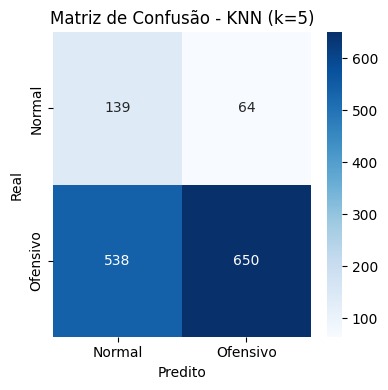


Resultados KNN: {'nome': 'KNN (k=5)', 'acuracia': 0.5672178289000719, 'f1_ofensivo': 0.6834910620399579}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Modelo KNN com k = 5 vizinhos
knn = KNeighborsClassifier(n_neighbors=5)

modelo_knn, resultados_knn = treinar_e_avaliar("KNN (k=5)", knn)

print("\nResultados KNN:", resultados_knn)

## 9. Treinando e avaliando o modelo Árvore de Decisão

Agora treinamos uma **Árvore de Decisão** com profundidade máxima limitada para tentar evitar overfitting.



================ Árvore de Decisão (max_depth=20) ================

Acurácia: 0.4306

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.1929    0.9113    0.3184       203
           1     0.9583    0.3485    0.5111      1188

    accuracy                         0.4306      1391
   macro avg     0.5756    0.6299    0.4148      1391
weighted avg     0.8466    0.4306    0.4830      1391



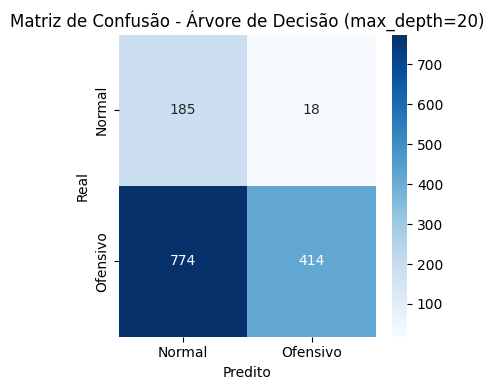


Resultados Árvore: {'nome': 'Árvore de Decisão (max_depth=20)', 'acuracia': 0.4306254493170381, 'f1_ofensivo': 0.5111111111111111}


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Árvore com profundidade máxima para evitar overfitting
tree = DecisionTreeClassifier(
    max_depth=20,
    random_state=42
)

modelo_tree, resultados_tree = treinar_e_avaliar("Árvore de Decisão (max_depth=20)", tree)

print("\nResultados Árvore:", resultados_tree)

## 10. Treinando e avaliando o modelo MLPClassifier (rede neural)

Por fim, treinamos uma rede neural simples (`MLPClassifier`) com duas camadas ocultas.
Este foi o modelo que apresentou melhor desempenho.



================ MLPClassifier (64,32) ================

Iteration 1, loss = 0.71080787
Iteration 2, loss = 0.67817863
Iteration 3, loss = 0.63499665
Iteration 4, loss = 0.57047754
Iteration 5, loss = 0.48346287
Iteration 6, loss = 0.38607638
Iteration 7, loss = 0.29188826
Iteration 8, loss = 0.20887644
Iteration 9, loss = 0.14469974
Iteration 10, loss = 0.09978223
Acurácia: 0.6887

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.2672    0.6502    0.3788       203
           1     0.9208    0.6953    0.7923      1188

    accuracy                         0.6887      1391
   macro avg     0.5940    0.6728    0.5855      1391
weighted avg     0.8255    0.6887    0.7320      1391



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


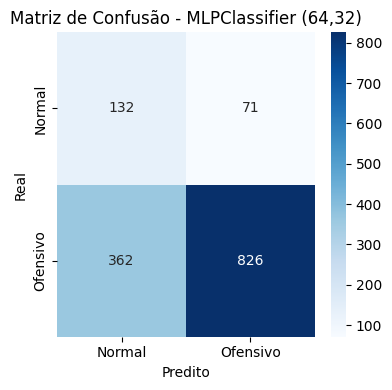


Resultados MLP: {'nome': 'MLPClassifier (64,32)', 'acuracia': 0.6887131560028756, 'f1_ofensivo': 0.7923261390887291}


In [ ]:
from sklearn.neural_network import MLPClassifier

# Rede MLP com 2 camadas ocultas
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=10,  # poucas iterações por causa do custo
    random_state=42,
    verbose=True
)

modelo_mlp, resultados_mlp = treinar_e_avaliar("MLPClassifier (64,32)", mlp)

print("\nResultados MLP:", resultados_mlp)

## 11. Salvando o modelo final para uso no Streamlit

Aqui salvamos o `pipeline` treinado (TF-IDF + MLP) em um arquivo `.pkl`,
que será carregado pela aplicação Streamlit.


In [ ]:
import joblib
import os

# Criar pasta models (se ainda não existir)
os.makedirs("./models", exist_ok=True)

# Caminho do arquivo do modelo
caminho_modelo = "./models/modelo_hatespeech_mlp.pkl"

# Salvar o pipeline inteiro (TF-IDF + MLP)
joblib.dump(modelo_mlp, caminho_modelo)

print("Modelo salvo em:", caminho_modelo)


Modelo salvo em: ./models/modelo_hatespeech_mlp.pkl


# **Referências**

1. Dataset OLID-BR
Trajano, D. (2022). OLID-BR: Offensive Language Identification Dataset in Brazilian Portuguese. Disponível em:
https://huggingface.co/datasets/dougtrajano/olid-br

2. TF-IDF — Vetorização de Texto
Ramos, J. (2003). Using TF-IDF to Determine Word Relevance in Document Queries. Proceedings of the First Instructional Conference on Machine Learning.

3. Scikit-Learn — Modelos de Machine Learning
Pedregosa, F. et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research.
https://scikit-learn.org/

4. Streamlit — Interface da Aplicação
Streamlit Documentation.
https://docs.streamlit.io/

5. Catálogo de dados de discurso de ódio
Vidgen, B., & Derczynski, L. (2020). Datasets for abusive language detection. PLoS ONE.
https://hatespeechdata.com